In [41]:
%matplotlib notebook
import mne
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from mne.time_frequency import tfr_array_morlet

In [2]:
# 31, 35, 38 and test folders for good data
# odd scalp on left, even on right

patient = 'UFSEEG031'
targetScalpElectrode = 'F7'

#filepath = '//ahcdfs.ahc.ufl.edu/files/NLGY/Groups/Epilepsy/KalamangalamLab/SEEG/%s/SEEG/EDF/TestClipSleep/TestClipSleep.edf' % patient
filepath = '../../../Desktop/TestClipSleep.edf'
raw = mne.io.read_raw_edf(filepath)

Extracting EDF parameters from C:\Users\the_m\Desktop\TestClipSleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
artifactElectrodes = {}
artifactElectrodes['UFSEEG031'] = ['LTP7', 'LTP8', 'LAH11', 'LAH12', 'LPH10', 'LPH11', 'LPH12','LOF15', 'LOF16']

In [4]:
scalpElectrodes = {}
scalpElectrodes[patient] = [i for i in raw.ch_names if len(i) == 2]
print(scalpElectrodes)

{'UFSEEG031': ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'PR']}


In [5]:
print(raw)
print(raw.info)

<RawEDF | TestClipSleep.edf, 148 x 1766016 (1724.6 s), ~142 kB, data not loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: LTP1, LTP2, LTP3, LTP4, LTP5, LTP6, LTP7, LTP8, LAM1, LAM2, ...
 chs: 148 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2001-01-01 02:05:22 UTC
 nchan: 148
 projs: []
 sfreq: 1024.0 Hz
>


Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


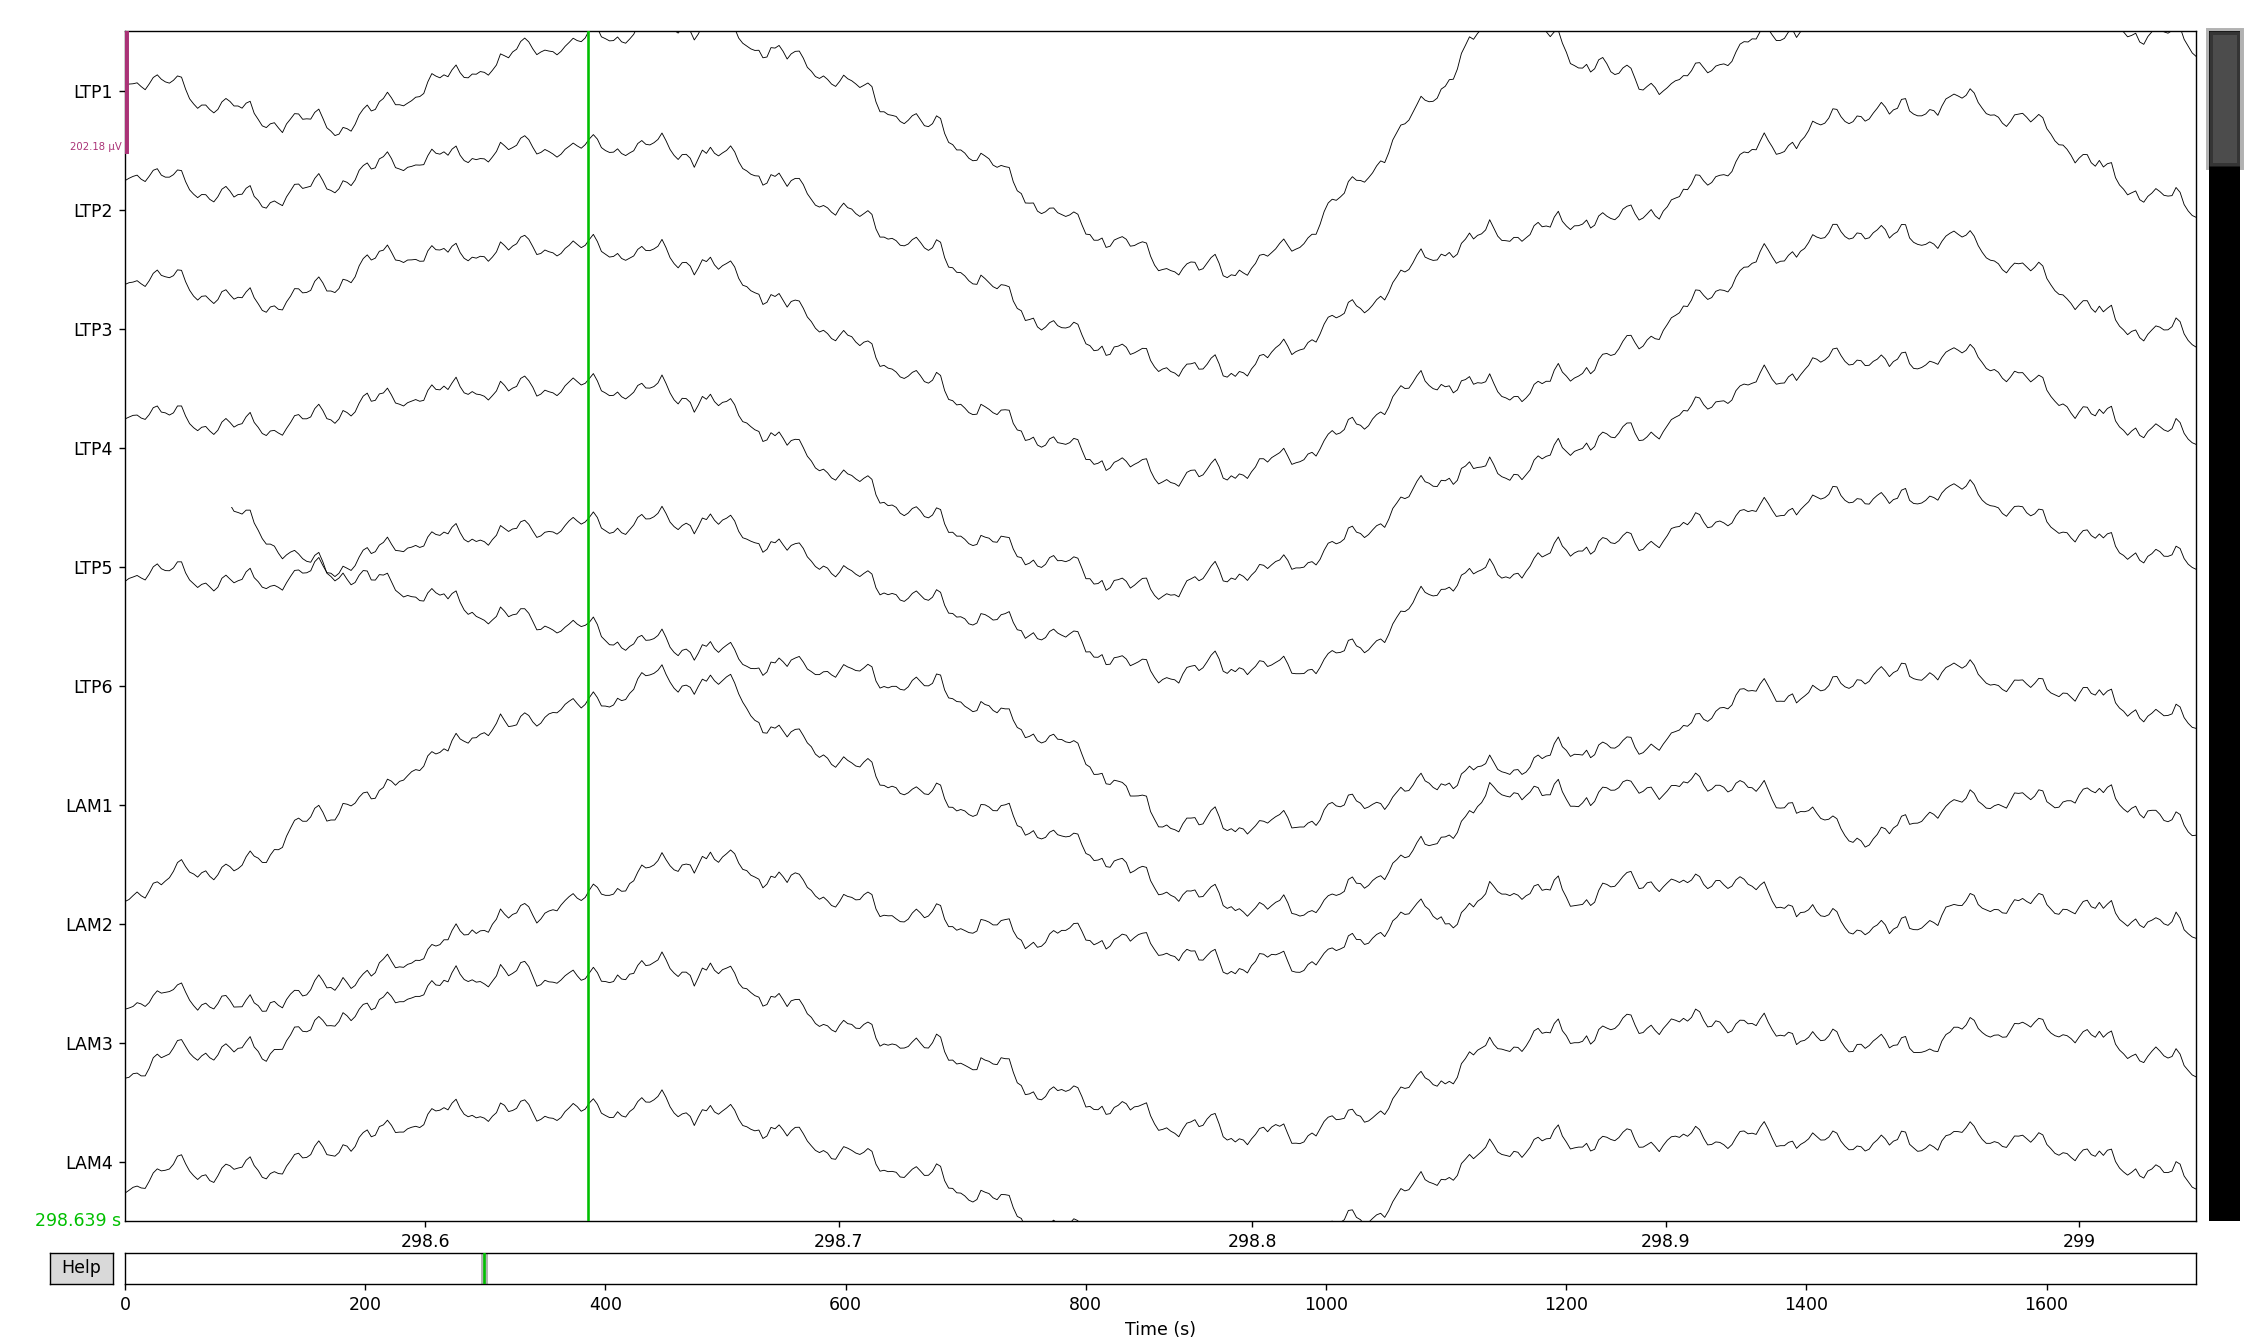

In [6]:
channels = [i for i in raw.ch_names if i not in artifactElectrodes[patient] and i[0] in {'L', 'R'}] + [targetScalpElectrode]
raw.pick_channels(channels).plot(duration=.5, n_channels=10);

In [7]:
df = raw.to_data_frame().drop(labels=['time'], axis=1)
data = df.to_numpy()
data = data - data.mean(axis=0, keepdims=True)
df

,LTP1,LTP2,LTP3,LTP4,LTP5,LTP6,LAM1,LAM2,LAM3,LAM4,...,LOF6,LOF7,LOF8,LOF9,LOF10,LOF11,LOF12,LOF13,LOF14,F7
0,-207.490211,-149.004822,-86.265949,-174.259876,-88.126848,83.873365,-192.071336,-314.890654,-185.691112,-139.434485,...,-86.000107,-33.629099,-77.227298,-67.922805,-33.629099,-54.098985,-79.088197,-208.553582,-174.525719,55.162356
1,-201.375830,-138.371115,-76.163928,-163.360327,-78.024826,94.241230,-181.969314,-303.991104,-174.791562,-129.332464,...,-73.239658,-19.273594,-62.871794,-53.833143,-19.539437,-42.136065,-68.454490,-194.995605,-162.296956,68.188647
2,-203.502571,-139.168643,-79.088197,-165.752911,-79.885725,93.177859,-182.500999,-306.117845,-180.905943,-131.725048,...,-74.568872,-19.007752,-63.669322,-53.833143,-20.336965,-42.933593,-71.378759,-198.451560,-163.892012,66.859434
3,-215.465492,-156.980102,-93.177859,-179.842573,-96.102129,79.354040,-195.261448,-318.878294,-198.185718,-147.143923,...,-89.721904,-32.565728,-77.758984,-67.125277,-34.692470,-57.554940,-85.468421,-214.933806,-179.576730,50.908873
4,-225.301671,-172.133135,-106.204150,-193.134707,-108.330892,66.859434,-206.692683,-330.575372,-212.807065,-159.638529,...,-103.279881,-46.123705,-88.924376,-79.885725,-46.389548,-70.315389,-100.089769,-231.416052,-192.868864,40.806851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766011,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,...,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921
1766012,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,...,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921
1766013,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,...,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921
1766014,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,...,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921,-0.132921


In [20]:
scalpData = data[:,-1]
seegData = data[:,:-1]

x_train, x_valid, y_train, y_valid = train_test_split(seegData, scalpData, test_size=0.33, random_state=42)

train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
valid = train.create_valid(x_valid, label=y_valid)

In [35]:
continueFlag = True
if continueFlag:
    inputModel = 'model.txt'
else:
    inputModel = ''

metric = 'mse'
num_iterations = 1000
early_stopping_rounds = 5

param = {'metric': metric, 
         'num_iterations': num_iterations,
         'early_stopping_rounds': early_stopping_rounds}

bst = lgb.train(param, 
                train, 
                valid_sets=[valid], 
                init_model = inputModel)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.325798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22185
[LightGBM] [Info] Number of data points in the train set: 1183230, number of used features: 87
[2101]	valid_0's l2: 208.506
Training until validation scores don't improve for 5 rounds
[2102]	valid_0's l2: 208.469
[2103]	valid_0's l2: 208.456
[2104]	valid_0's l2: 208.448
[2105]	valid_0's l2: 208.394
[2106]	valid_0's l2: 208.352
[2107]	valid_0's l2: 208.322
[2108]	valid_0's l2: 208.315
[2109]	valid_0's l2: 208.299
[2110]	valid_0's l2: 208.278
[2111]	valid_0's l2: 208.249
[2112]	valid_0's l2: 208.205
[2113]	valid_0's l2: 208.146
[2114]	valid_0's l2: 208.116
[2115]	valid_0's l2: 208.067
[2116]	valid_0's l2: 208.041
[2117]	valid_0's l2: 208.033
[2118]	valid_0's l2: 208.013
[2119]	valid_0's l2: 207.994
[2120]	valid_0's l2: 207.956
[2121]	valid_0's l2: 207.898
[2122]	valid_0's l2: 207.841
[2123]	

[2372]	valid_0's l2: 200.297
[2373]	valid_0's l2: 200.265
[2374]	valid_0's l2: 200.237
[2375]	valid_0's l2: 200.212
[2376]	valid_0's l2: 200.182
[2377]	valid_0's l2: 200.152
[2378]	valid_0's l2: 200.15
[2379]	valid_0's l2: 200.117
[2380]	valid_0's l2: 200.058
[2381]	valid_0's l2: 200.044
[2382]	valid_0's l2: 200.005
[2383]	valid_0's l2: 199.973
[2384]	valid_0's l2: 199.949
[2385]	valid_0's l2: 199.929
[2386]	valid_0's l2: 199.874
[2387]	valid_0's l2: 199.834
[2388]	valid_0's l2: 199.806
[2389]	valid_0's l2: 199.768
[2390]	valid_0's l2: 199.744
[2391]	valid_0's l2: 199.699
[2392]	valid_0's l2: 199.665
[2393]	valid_0's l2: 199.635
[2394]	valid_0's l2: 199.61
[2395]	valid_0's l2: 199.597
[2396]	valid_0's l2: 199.551
[2397]	valid_0's l2: 199.509
[2398]	valid_0's l2: 199.485
[2399]	valid_0's l2: 199.448
[2400]	valid_0's l2: 199.42
[2401]	valid_0's l2: 199.378
[2402]	valid_0's l2: 199.364
[2403]	valid_0's l2: 199.341
[2404]	valid_0's l2: 199.324
[2405]	valid_0's l2: 199.301
[2406]	valid_0's 

[2658]	valid_0's l2: 193.07
[2659]	valid_0's l2: 193.035
[2660]	valid_0's l2: 193.006
[2661]	valid_0's l2: 192.982
[2662]	valid_0's l2: 192.969
[2663]	valid_0's l2: 192.941
[2664]	valid_0's l2: 192.932
[2665]	valid_0's l2: 192.911
[2666]	valid_0's l2: 192.868
[2667]	valid_0's l2: 192.826
[2668]	valid_0's l2: 192.794
[2669]	valid_0's l2: 192.756
[2670]	valid_0's l2: 192.723
[2671]	valid_0's l2: 192.717
[2672]	valid_0's l2: 192.701
[2673]	valid_0's l2: 192.683
[2674]	valid_0's l2: 192.666
[2675]	valid_0's l2: 192.64
[2676]	valid_0's l2: 192.639
[2677]	valid_0's l2: 192.629
[2678]	valid_0's l2: 192.602
[2679]	valid_0's l2: 192.604
[2680]	valid_0's l2: 192.597
[2681]	valid_0's l2: 192.604
[2682]	valid_0's l2: 192.579
[2683]	valid_0's l2: 192.544
[2684]	valid_0's l2: 192.532
[2685]	valid_0's l2: 192.491
[2686]	valid_0's l2: 192.45
[2687]	valid_0's l2: 192.438
[2688]	valid_0's l2: 192.422
[2689]	valid_0's l2: 192.376
[2690]	valid_0's l2: 192.341
[2691]	valid_0's l2: 192.312
[2692]	valid_0's 

[2943]	valid_0's l2: 186.758
[2944]	valid_0's l2: 186.737
[2945]	valid_0's l2: 186.729
[2946]	valid_0's l2: 186.719
[2947]	valid_0's l2: 186.711
[2948]	valid_0's l2: 186.675
[2949]	valid_0's l2: 186.641
[2950]	valid_0's l2: 186.606
[2951]	valid_0's l2: 186.576
[2952]	valid_0's l2: 186.542
[2953]	valid_0's l2: 186.542
[2954]	valid_0's l2: 186.512
[2955]	valid_0's l2: 186.477
[2956]	valid_0's l2: 186.434
[2957]	valid_0's l2: 186.414
[2958]	valid_0's l2: 186.389
[2959]	valid_0's l2: 186.381
[2960]	valid_0's l2: 186.367
[2961]	valid_0's l2: 186.358
[2962]	valid_0's l2: 186.33
[2963]	valid_0's l2: 186.302
[2964]	valid_0's l2: 186.286
[2965]	valid_0's l2: 186.283
[2966]	valid_0's l2: 186.274
[2967]	valid_0's l2: 186.263
[2968]	valid_0's l2: 186.253
[2969]	valid_0's l2: 186.23
[2970]	valid_0's l2: 186.217
[2971]	valid_0's l2: 186.192
[2972]	valid_0's l2: 186.194
[2973]	valid_0's l2: 186.169
[2974]	valid_0's l2: 186.155
[2975]	valid_0's l2: 186.131
[2976]	valid_0's l2: 186.105
[2977]	valid_0's

In [36]:
print(bst.num_trees())
bst.save_model('model.txt');

3100


In [37]:
ypred = bst.predict(seegData)

<IPython.core.display.Javascript object>


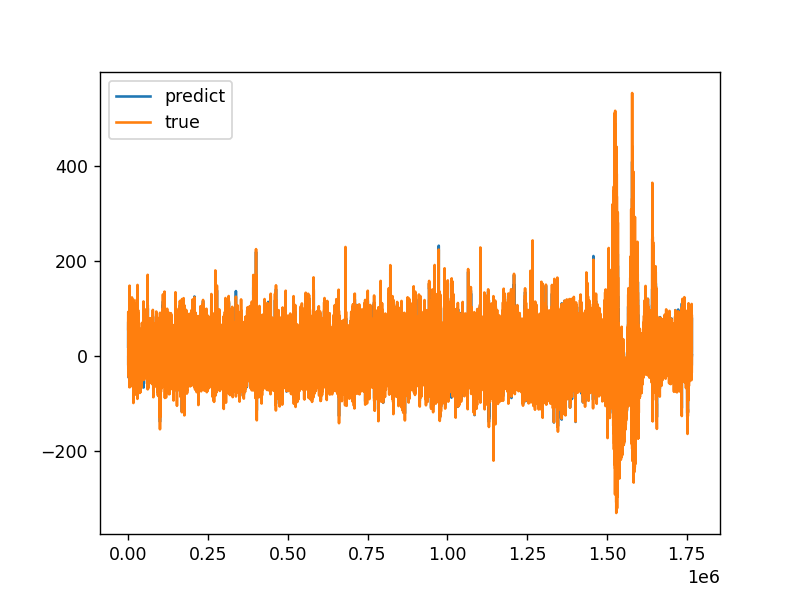

In [38]:
plt.figure()
plt.plot(ypred, label='predict')
plt.plot(scalpData, label='true')
plt.legend()
plt.show()